## Part 3: Can you do it for the S&P500 market portfolio? (Max 10 point)
Try to repeat your analysis for the S&P500 portfolio. The data can be obtained from Course 2 "Fundamentals of Machine Learning in Finance" in this Specialization.

## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [pandas](http://pandas.pydata.org/) Python data analysis library
- [pandas](http://scikit-learn.org/stable/) scikit-learn - machine learning in Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.

In [1]:
import pandas as pd
import numpy as np
import sklearn.decomposition
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
import sys

import matplotlib.pyplot as plt
%matplotlib inline

print("Package Versions:")
print("  scikit-learn: %s" % sklearn.__version__)
print("  tensorflow: %s" % tf.__version__)

sys.path.append("..")
import grading

try:
    import sklearn.model_selection
    import sklearn.linear_model
except:
    print("Looks like an older version of sklearn package")

try:
    import pandas as pd
    print("  pandas: %s"% pd.__version__)
except:
    print("Missing pandas package")

Package Versions:
  scikit-learn: 0.18.2
  tensorflow: 1.10.1
  pandas: 0.19.2


#### Dataset:  daily prices of  stocks from S&P 500 index  ####
For this exercise we will be working with S&P 500 Index stock prices dataset. 
The following cell computes returns based for a subset of S&P 500 index stocks. It starts with stocks price data:

In [2]:
import os
# load dataset

df_cap = pd.read_csv('/home/jovyan/work/readonly/spx_holdings_and_spx_closeprice.csv',
                     date_parser=lambda dt: pd.to_datetime(dt, format='%Y-%m-%d'),
                     index_col = 0).dropna()
n_stocks_show = 5
print('Asset prices shape', df_cap.shape)
df_cap.iloc[:,:n_stocks_show].head()

Asset prices shape (3493, 419)


,A,AA,AAPL,ABC,ABT
2000-01-27,46.1112,78.9443,3.9286,4.5485,13.7898
2000-01-28,45.8585,77.8245,3.6295,4.5485,14.2653
2000-01-31,44.5952,78.0345,3.7054,4.3968,14.5730
2000-02-01,47.8377,80.7640,3.5804,4.5333,14.7128
2000-02-02,51.5434,83.4934,3.5290,4.5788,14.7968


In [3]:
# drop SPX
df_cap.drop(['SPX'],axis="columns",inplace=True)
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)

In [4]:
n_stocks_show = 5
print('Asset prices shape', df_cap.shape)
df_cap.iloc[:,-n_stocks_show:].head()

Asset prices shape (3493, 418)


,TER,TGNA,THC,X,MAR.1
date,,,,,
2010-01-04,65.8677,22.1921,60.9705,20.7086,12.2457
2010-01-05,60.3487,21.7558,62.3032,20.1183,12.0742
2010-01-06,62.1484,22.0533,60.6373,19.5772,12.1722
2010-01-07,67.3674,22.2120,60.4708,19.5772,12.5151
2010-01-08,68.9271,22.6483,62.4698,19.5281,12.3192


In [18]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10
short_rolling = df_cap.rolling(window=window_1).mean()

# Calculating the long-window (30 days) simple moving average

window_2 = 30

long_rolling = df_cap.rolling(window=window_2).mean()

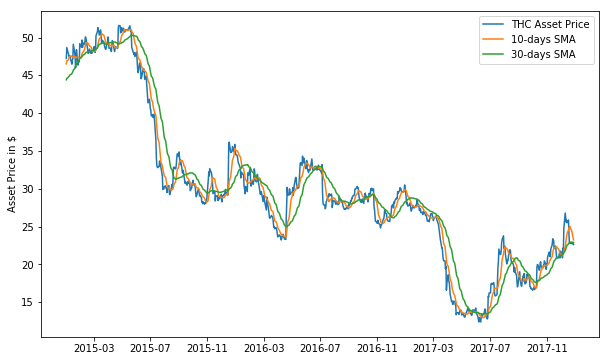

In [19]:
ticker = 'THC'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)


ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, str(ticker)], label= str(ticker) + ' Asset Price')
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, str(ticker)], 
          label = '%d-days SMA' % window_1)
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, str(ticker)], 
         label = '%d-days SMA' % window_2)

ax.legend(loc='best')
ax.set_ylabel('Asset Price in $')

plt.show()

In [20]:
# Scaling Data for easier convergence

from sklearn.preprocessing import MinMaxScaler

# Converting data to a log space
df_cap_log = np.log(df_cap)
short_rolling_log = df_cap_log.rolling(window=window_1).mean()
long_rolling_log = df_cap_log.rolling(window=window_2).mean()

In [21]:
# Using MinMaxScaler with defined region (epsilon, 1) to make data non-negative and on the same scale
epsilon = 0.1
df_cap_scaler = MinMaxScaler([epsilon, 1]).fit(df_cap_log)

df_cap_norm = pd.DataFrame(data=df_cap_scaler.transform(df_cap_log),
                           columns=df_cap_log.columns,
                           index=df_cap_log.index)

# Rescaling rolling averages using the same scaling factors as the for the market data
long_rolling_norm = pd.DataFrame(data=df_cap_scaler.transform(long_rolling_log.dropna()),
                                 columns=long_rolling_log.columns,
                                 index=long_rolling_log.dropna().index)

short_rolling_norm = pd.DataFrame(data=df_cap_scaler.transform(short_rolling_log.dropna()),
                                  columns=short_rolling_log.columns,
                                  index=short_rolling_log.dropna().index)

df_cap_norm.iloc[:5,-10:]

,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1
date,,,,,,,,,,
2010-01-04,0.593932,0.116318,0.659452,0.623360,0.156705,0.882433,0.921228,0.727151,0.363194,0.198388
2010-01-05,0.555032,0.106807,0.645333,0.648808,0.149188,0.860628,0.916334,0.731944,0.354568,0.189795
2010-01-06,0.622097,0.113493,0.658467,0.668935,0.142846,0.867950,0.919682,0.725936,0.346435,0.194720
2010-01-07,0.615168,0.104873,0.647393,0.682027,0.146662,0.888043,0.921449,0.725327,0.346435,0.211647
2010-01-08,0.647447,0.100000,0.642214,0.677692,0.147924,0.893746,0.926245,0.732536,0.345686,0.202034


In [22]:
def plot_ticker(ticker, data_dict, start_date = '2015-01-01', end_date = '2017-12-31'):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)

    for i in range(len(data_dict)):
        ax.plot(list(data_dict.values())[i].loc[start_date:end_date, :].index,
                list(data_dict.values())[i].loc[start_date:end_date, ticker],
                label=list(data_dict.keys())[i])

    ax.legend(loc='best')
    ax.set_ylabel('Asset Price Log Scale')
    plt.title(ticker)

    plt.show()



### Introduce Exponential Weighting to Signals, this seems to generate better results than Simple MA

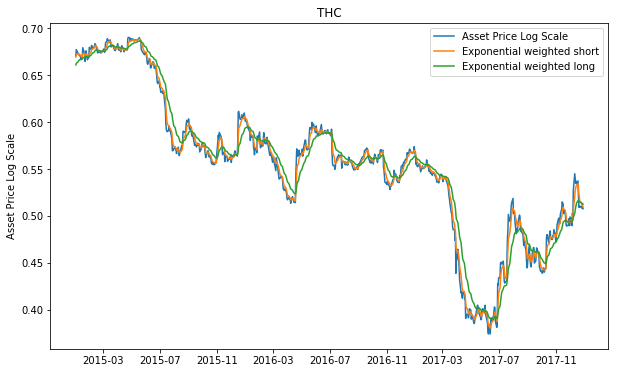

Scaled Asset Price:


,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1
date,,,,,,,,,,
2010-01-04,0.593932,0.116318,0.659452,0.623360,0.156705,0.882433,0.921228,0.727151,0.363194,0.198388
2010-01-05,0.555032,0.106807,0.645333,0.648808,0.149188,0.860628,0.916334,0.731944,0.354568,0.189795
2010-01-06,0.622097,0.113493,0.658467,0.668935,0.142846,0.867950,0.919682,0.725936,0.346435,0.194720
2010-01-07,0.615168,0.104873,0.647393,0.682027,0.146662,0.888043,0.921449,0.725327,0.346435,0.211647
2010-01-08,0.647447,0.100000,0.642214,0.677692,0.147924,0.893746,0.926245,0.732536,0.345686,0.202034


Scaled signal #1:


,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1
date,,,,,,,,,,
2010-01-04,-0.021832,-0.027256,-0.007137,0.013608,-0.015989,-0.008237,-0.001771,0.002197,-0.007917,-0.014438
2010-01-05,0.023599,0.001016,0.001894,0.019569,-0.024544,-0.002748,0.000031,-0.001286,-0.012844,-0.001370
2010-01-06,0.011486,-0.024692,-0.004366,0.019570,-0.008318,0.005837,0.000661,-0.001138,-0.008674,0.027981
2010-01-07,0.025458,-0.031581,-0.005567,0.010596,-0.002770,0.006034,0.002177,0.002546,-0.006542,0.002183
2010-01-08,0.018335,0.008430,-0.005351,0.004798,0.015033,0.008396,0.001993,-0.000493,-0.008713,0.027207


Scaled signal #2:


,SPLS,STJ,SVU,SWY,TEG,TER,TGNA,THC,X,MAR.1
date,,,,,,,,,,
2010-01-04,-0.006238,-0.007788,-0.002039,0.003888,-0.004568,-0.002353,-0.000506,6.277173e-04,-0.002262,-0.004125
2010-01-05,0.005142,-0.001584,0.000052,0.006567,-0.008025,-0.001342,-0.000112,-2.187305e-04,-0.004189,-0.001374
2010-01-06,0.003517,-0.008560,-0.001555,0.007883,-0.004971,0.000961,0.000082,-2.777324e-04,-0.003806,0.006926
2010-01-07,0.008334,-0.011874,-0.002160,0.006426,-0.003739,0.001486,0.000570,6.926747e-04,-0.003655,0.001615
2010-01-08,0.008002,-0.002703,-0.002417,0.005126,0.001283,0.002601,0.000671,7.620793e-07,-0.004527,0.008898


In [23]:
exponential_weighted_short = df_cap_norm.ewm(span=5, adjust=False).mean()
exponential_weighted_long  = df_cap_norm.ewm(span=20, adjust=False).mean()
data_dict = {'Asset Price Log Scale': df_cap_norm, 
             'Exponential weighted short': exponential_weighted_short, 
             'Exponential weighted long': exponential_weighted_long}
plot_ticker('THC', data_dict)

# For the signals, we use the percentage change from one point to another in the moving average.
# Again we drop the NaN values (generated because the first value does not have a percentage change)
signal_3_1 = exponential_weighted_short.pct_change(periods=1).shift(-1).dropna().copy()
signal_3_2 = exponential_weighted_long.pct_change(periods=1).shift(-1).dropna().copy()

# Now all that is left to do is to make sure our three datasets all have the same values for same date range.
market_3 = df_cap_norm[df_cap_norm.index.isin(signal_3_1.index) & df_cap_norm.index.isin(signal_3_2.index)]
signal_3_1 = signal_3_1[signal_3_1.index.isin(market_3.index)]
signal_3_2 = signal_3_2[signal_3_2.index.isin(market_3.index)]

print('Scaled Asset Price:')
display(market_3.iloc[:5,-10:])
print('Scaled signal #1:')
display(signal_3_1.iloc[:5,-10:])
print('Scaled signal #2:')
display(signal_3_2.iloc[:5,-10:])

### We now create a class that holds the model algorithm. This allows us to reuse the model in subsequent parts of this assignment

In [15]:
# Create a model class and train it

import time
from datetime import timedelta
class IRL_model():
    
    def __init__(self, num_timesteps, num_stocks, learning_rate=1e-3):
        
        self.t = num_timesteps
        self.n = num_stocks
        print('Setting up model with t={} time steps and n={} stocks'.format(self.t,self.n))        
        
        print('Setting up tensorflow...', end=' ')        
        # here we set up the graph
        tf.reset_default_graph()
        self.x  = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'x' )  # market
        self.z1 = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'z1' ) # signal 1
        self.z2 = tf.placeholder(shape = (None, self.n), dtype = tf.float32, name = 'z2' ) # sigmal 2
        

        # weights
        self.w1_init = tf.random_normal([self.n], mean=0.5, stddev=0.1)
        self.w2_init = 1 - self.w1_init
        self.w1      = tf.get_variable('w1', initializer = self.w1_init)
        self.w2      = tf.get_variable('w2', initializer = self.w2_init)
        self.W1      = self.w1*tf.ones(self.n)
        self.W2      = self.w2*tf.ones(self.n)
        self.k       = 2
        
        # parameters
        self.sigma = tf.get_variable('sigma', initializer = tf.random_uniform([self.n], minval=0.0, maxval=0.1))
        self.kappa = tf.get_variable('kappa', initializer = tf.random_uniform([self.n], minval=0.0, maxval=1.0))
        
        self.mu    = tf.zeros([self.n])
        self.Sigma = self.sigma * tf.ones([self.n])
        self.Kappa = self.kappa * tf.ones([self.n])

        self.signals1 = tf.multiply(self.W1, self.z1)
        self.signals2 = tf.multiply(self.W2, self.z2)
        self.scale    = tf.slice(self.x, [0,0], [1,-1])
        self.signals  = tf.multiply(self.scale, tf.cumprod(1 + tf.add(self.signals1, self.signals2)))
        
        # now we add some non-negative constraints on the weights
        self.w1_abs      = self.w1.assign(tf.maximum(0., self.w1))
        self.w2_abs      = self.w2.assign(tf.maximum(0., self.w2))
        self.constraints = tf.group(self.w1_abs, self.w2_abs)

        # expression
               
        self.r = tf.divide( tf.subtract( tf.manip.roll( self.x, shift = -1, axis = 0), self.x),self.x)
        self.v = tf.subtract( self.r, tf.multiply( self.Kappa, tf.subtract( self.signals, self.x) ) )
        self.V = tf.slice(self.v, [0,0], [tf.shape(self.v)[0]-1, -1])
       
        
        # negative log-likelyhood
        self.distribution = tf.contrib.distributions.MultivariateNormalDiag(loc=self.mu, scale_diag=self.Sigma)
        self.log_prob     = self.distribution.log_prob(self.V)
        self.reg_term     = tf.reduce_sum(tf.square(self.w1 + self.w2 - 1))
        self.neg_log_likelihood = -tf.reduce_sum(self.log_prob) + 0.01 * self.reg_term
        
        # configure the optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.train_op  = self.optimizer.minimize(self.neg_log_likelihood)
        
        print('Model Ready!')
        return
    
    def fit(self, market, signal_1, signal_2, epochs=1000, tol=1e-3):
        start = time.time()
        assert not np.any(np.isnan(market))
        assert not np.any(np.isnan(signal_1))
        assert not np.any(np.isnan(signal_2))
        
        with tf.Session() as sess:
          
            sess.run(tf.global_variables_initializer())
            
            # run the first iteration and calculate initial loss
            res = []
            self.loss = []
            res.append(sess.run(self.neg_log_likelihood, \
                                feed_dict = {self.x: market, self.z1: signal_1, self.z2: signal_2}))
                        
            # now iterate loss minimization in a loop
            e=1
            while True:
                # solve the optimiser
                sess.run(self.train_op, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
                # abide by contraints
                sess.run(self.constraints) 

                # update loss
                res.append(sess.run(self.neg_log_likelihood, \
                                    feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2}))
                loss_ = np.abs(res[-1] - res[-2])
                self.loss.append(loss_)

                if (e % 200 == 0) or (e == 1):
                    print('Epoch {:5}: Loss: {}'.format(e, loss_))

                if loss_ < tol:
                    print('Converged after {} epochs. Loss: {}'.format(e, loss_))
                    break

                if e >= epochs:
                    print('Specified maximum epochs ({}) reached without convergence. Loss: {}'.format(epochs, loss_))
                    break

                e += 1
                
            end = time.time()            
            
            # Save the coefficients
            self.coefficients = pd.DataFrame([], index = market.columns, \
                                             columns = ['kappa', 'sigma', 'w1', 'w2'] )  # 'theta', 'g',
            self.coefficients['kappa']   = sess.run(self.kappa)
            self.coefficients['sigma']   = sess.run(self.sigma)
            self.coefficients['w1']      = sess.run(self.W1)
            self.coefficients['w2']      = sess.run(self.W2)
            
            est_ = sess.run(self.signals, feed_dict={self.x: market, self.z1: signal_1, self.z2: signal_2})
            self.estimation = pd.DataFrame(est_, index=market.index, columns=market.columns)
            
        print('Training Complete. Elapsed time:', timedelta(seconds=end-start))


In [24]:
part3_model = IRL_model(market_3.shape[0], market_3.shape[1], learning_rate=1.5e-3)
part3_model.fit(market_3, signal_3_1, signal_3_2, epochs=1000, tol=1)

Setting up model with t=3492 time steps and n=418 stocks
Setting up tensorflow... Model Ready!
Epoch     1: Loss: 91577968.0
Epoch   200: Loss: 307.5
Epoch   400: Loss: 213.25
Epoch   600: Loss: 150.25
Epoch   800: Loss: 103.5
Epoch  1000: Loss: 66.75
Specified maximum epochs (1000) reached without convergence. Loss: 66.75
Training Complete. Elapsed time: 0:29:27.091906


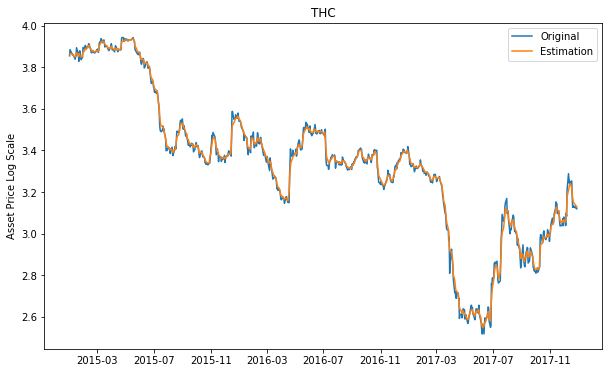

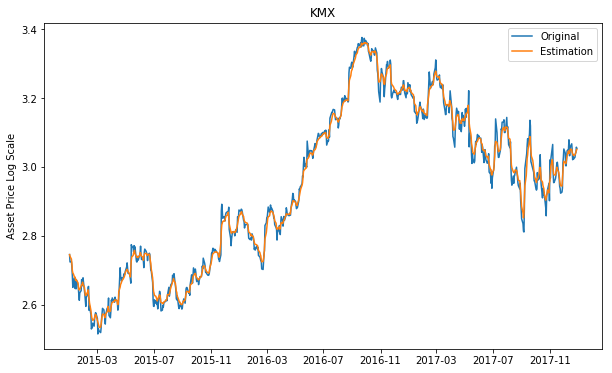

In [25]:
estimation_3 = df_cap_scaler.inverse_transform(part3_model.estimation)
df_est = pd.DataFrame(estimation_3, columns=part3_model.estimation.columns, index=part3_model.estimation.index)

data_dict = {'Original': df_cap_log, 'Estimation': df_est}

plot_ticker('THC', data_dict)

ticker = np.random.choice(df_cap.columns.values)
plot_ticker(ticker, data_dict)

In [26]:
part3_model.coefficients.head()

,kappa,sigma,w1,w2
A,1.654060,0.025309,0.999021,0.000000
AA,0.723547,0.028681,0.998684,0.000000
AAPL,2.093068,0.019401,1.000420,0.000000
ABC,0.907728,0.014574,0.844413,0.152893
ABT,1.172571,0.030530,1.000984,0.000000


In [27]:
print("Part3_model can be applied to SnP500, but training time takes a lot longer due to 418 tickers compared to 30 tickers in DJI")

print("End of Part 3")

Part3_model can be applied to SnP500, but training time takes a lot longer due to 418 tickers compared to 30 tickers in DJI
End of Part 3
